In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import database
reload(database)
db = database.thomas_18_db

In [3]:
figdir_root='/mnt/home/szheng/ceph/place_variability/fig/explore_imaging/'
figdir = os.path.join(figdir_root,'pv_corr')
figdir= misc.get_or_create_subdir(figdir)

In [4]:
sys.path.append('/mnt/home/szheng/projects/place_variability/code/thomas_18_data')

In [5]:
import fr_map_thomas_all_sess as fmtas
reload(fmtas)

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


<module 'fr_map_thomas_all_sess' from '/mnt/home/szheng/projects/place_variability/code/thomas_18_data/fr_map_thomas_all_sess.py'>

In [6]:
%%time
fr_map_all = fmtas.main(force_reload=False,load_only=True,dosave=False)

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/fr_map_all_mask_False.p exists; loading---
CPU times: user 316 ms, sys: 2.66 s, total: 2.98 s
Wall time: 8.85 s


In [14]:
fr_map_all_noma.keys()

dict_keys(['fr_map_all', 'fr_map_trial_all', 'fr_map_trial_df_all'])

In [11]:
db

,region,exp_ind,day_ind,data_dir_full
54,CA1,0,0,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
48,CA1,1,0,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
60,CA1,3,0,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
75,CA1,4,0,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
58,CA1,5,0,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
...,...,...,...,...
17,DG,10,1,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
24,DG,11,1,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
22,DG,11,2,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
20,DG,11,3,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...


# get per session per cell spatial information, lap to lap corr, frac of trials active, cv, switchyness on all pos


In [10]:
fr_map_all.keys()

dict_keys(['fr_map_all', 'fr_map_trial_all', 'fr_map_trial_df_all'])

In [7]:
fr_map_trial_df_all = fr_map_all['fr_map_trial_df_all']

occu_map = fr_map_all['occu_map_all']

frmap = fr_map_all['fr_map_all']
fr_map_trial_all = fr_map_all['fr_map_trial_all']

In [79]:
reload(pa)

<module 'place_cell_analysis' from '/mnt/home/szheng/projects/util_code/place_cell_analysis.py'>

In [85]:
# def get_si_from_frmap_and_occu(frmap,occu_map):
#     si_all = {}
#     for kk, row in occu_map.iterrows():
#         frmap_one=frmap.loc[kk].dropna(axis=1)
#         row = row.dropna()
#         si_one = pa.get_si_one_field(frmap_one,row)
#         si_all[kk] = si_one
#     si_all = pd.concat(si_all,axis=0)
#     return si_all

In [8]:
reload(pa)
si_all = pa.get_si_from_frmap_and_occu(frmap,occu_map)

/mnt/home/szheng/projects/util_code/place_cell_analysis.py:211: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=frmap.loc[kk].dropna(axis=1)
/mnt/home/szheng/projects/util_code/place_cell_analysis.py:203: RuntimeWarning: invalid value encountered in true_divide
  div = (fr_map_v / fr_mean[:,None])


In [118]:
# def get_fr_cv(fr_map_trial_df_all,level_l = [0,1,2,3,4]):
#     '''
#     fr_map_trial_df_all: (region x exp x day x isnovel x uid x pos) x trial
#     '''
#     # rectify negative:
#     fr_map_trial_df_all_v = fr_map_trial_df_all.values
#     fr_map_trial_df_all_v[fr_map_trial_df_all_v<0] = 0.
#     fr_map_trial_df_all = pd.DataFrame(fr_map_trial_df_all_v,index=fr_map_trial_df_all.index,columns=fr_map_trial_df_all.columns)
    

#     gpb = fr_map_trial_df_all.groupby(level=level_l)
#     mean_over_pos = gpb.mean() # position out
#     mean_fr = mean_over_pos.mean(axis=1)
#     fr_cv = mean_over_pos.std(axis=1) / mean_fr

#     return fr_cv, mean_fr

In [9]:
reload(pa)
fr_cv,mean_fr = pa.get_fr_cv(fr_map_trial_df_all,level_l=(0,1,2,3,4))

In [10]:
per_cell_metrics_d = {'si':si_all,'fr_cv':fr_cv,'mean_fr':mean_fr}
per_cell_metrics = pd.concat(per_cell_metrics_d,axis=1)

In [ ]:
# 

# lap to lap corr per cell

In [213]:
%%time
gpb=fr_map_trial_df_all.groupby(level=(0,1,4),sort=False)
corr_all = {}
for k,val in gpb:
    val.dropna(axis=1,how='all')
    val_droplevel=val.dropna(axis=1,how='all').droplevel((0,1))
    val_restacked=val_droplevel.unstack(level=(0,1)).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1).dropna(axis=1,how='all')
    corr=val_restacked.corr()
    corr_all[k]=corr
corr_all = pd.concat(corr_all,axis=0)

CPU times: user 3min 24s, sys: 4.33 s, total: 3min 28s
Wall time: 3min 28s


In [214]:
fr_map_trial_df_all_per_uid=fr_map_trial_df_all.unstack(level=(2,3)).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1).dropna(axis=1,how='all')



In [217]:
%%time
gpb = fr_map_trial_df_all_per_uid.groupby(level=(0,1,2),sort=False)
corr_all = {}
for k,val in gpb:
    corr = val.dropna(axis=1,how='all').corr()
    corr_all[k]  = corr
corr_all = pd.concat(corr_all,axis=0)

CPU times: user 2min 29s, sys: 3.69 s, total: 2min 33s
Wall time: 2min 33s


In [237]:
gpb=corr_all.groupby(level=(0,1,2))
for k,val in gpb:
    val

In [244]:
isnovel =0
corr_one=val.loc[k].loc[(slice(None),isnovel),(slice(None),isnovel)].dropna(axis=1,how='all').dropna(axis=0,how='all')

In [289]:
region='CA1'
row=per_cell_metrics.loc[region].query('si>1.').sample()
exp,day,isnovel,uid=row.index[0]

In [290]:
corr_one=corr_all.loc[(region,exp,uid,slice(None),isnovel),(slice(None),isnovel)].dropna(axis=1,how='all').dropna(axis=0,how='all')

In [291]:
corr_vals_all = {}
for offset in range(1,20):
    corr_vals=np.diag(corr_one,offset)
    corr_vals = pd.Series(corr_vals)
    corr_vals_all[offset] = corr_vals
corr_vals_all = pd.concat(corr_vals_all).reset_index(level=0).rename({'level_0':'offset',0:'corr'},axis=1).reset_index(drop=True)

<Axes: xlabel='offset', ylabel='corr'>

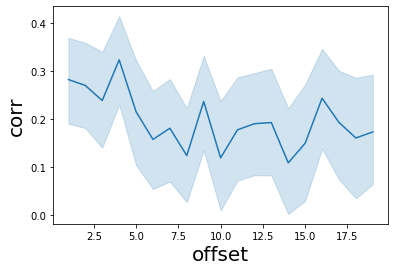

In [292]:
sns.lineplot(data=corr_vals_all,x='offset',y='corr')

In [262]:
corr_vals_all

,offset,corr
0,1,-0.621859
1,1,-0.644242
2,1,-0.153053
3,1,-0.329447
4,1,-0.101283
...,...,...
92,9,-0.094085
93,9,-0.456271
94,9,-0.104724
95,9,0.547472


In [232]:
val.index.get_level_values(6).unique()

IndexError: Too many levels: Index has only 6 levels, not 7

In [229]:
#### val_restacked

In [210]:
val_restacked.corr()

0                                                        \
               0                                                         
              0         1         2         3         4   5         6    
0 0 0   1.000000 -0.621859  0.404868  0.438196 -0.465389 NaN  0.051129   
    1  -0.621859  1.000000 -0.644242 -0.228337  0.276830 NaN  0.026286   
    2   0.404868 -0.644242  1.000000 -0.153053 -0.461409 NaN -0.133612   
    3   0.438196 -0.228337 -0.153053  1.000000 -0.329447 NaN -0.132338   
    4  -0.465389  0.276830 -0.461409 -0.329447  1.000000 NaN -0.101283   
...          ...       ...       ...       ...       ...  ..       ...   
4 1 15  0.851173 -0.558259  0.187969  0.465911 -0.390644 NaN  0.480613   
    16 -0.188960  0.044848  0.407688 -0.654306  0.332554 NaN -0.382234   
    17 -0.100852 -0.206881  0.555955 -0.391511 -0.171170 NaN -0.248511   
    18 -0.050070 -0.279190  0.663844 -0.415032 -0.189615 NaN -0.374397   
    19 -0.353604  0.093967 -0.065710 -0.199266  0.502710 NaN  0.515693   

                                ...         4                                \
                                ...         1                                 
              7   8         9   ...        10        11        12        13   
0 0 0   0.910873 NaN -0.214072  ...  0.038946 -0.162134 -0.041579  0.226044   
    1  -0.514068 NaN  0.566944  ... -0.342621  0.068464 -0.041948 -0.523586   
    2   0.228041 NaN -0.210317  ...  0.757140  0.276258  0.263466  0.785122   
    3   0.513802 NaN -0.246430  ... -0.428645 -0.522685  0.091567 -0.280219   
    4  -0.339620 NaN  0.181257  ... -0.255445  0.253433 -0.101881 -0.420858   
...          ...  ..       ...  ...       ...       ...       ...       ...   
4 1 15  0.905962 NaN -0.178062  ... -0.275841 -0.167044  0.204404  0.136986   
    16 -0.393621 NaN  0.317737  ...  0.723355  0.709740 -0.146503  0.278736   
    17 -0.217990 NaN -0.078022  ...  0.842151  0.690324 -0.147929  0.664416   
    18 -0.241268 NaN -0.086429  ...  0.962320  0.676124 -0.164398  0.659516   
    19 -0.122863 NaN  0.260534  ... -0.371751  0.146191  0.701763 -0.037689   

                                                                    
                                                                    
              14        15        16        17        18        19  
0 0 0  -0.478215  0.851173 -0.188960 -0.100852 -0.050070 -0.353604  
    1   0.326663 -0.558259  0.044848 -0.206881 -0.279190  0.093967  
    2  -0.220970  0.187969  0.407688  0.555955  0.663844 -0.065710  
    3   0.252158  0.465911 -0.654306 -0.391511 -0.415032 -0.199266  
    4  -0.384614 -0.390644  0.332554 -0.171170 -0.189615  0.502710  
...          ...       ...       ...       ...       ...       ...  
4 1 15 -0.334688  1.000000 -0.475068 -0.268419 -0.293223 -0.007203  
    16 -0.497699 -0.475068  1.000000  0.531246  0.675512 -0.011881  
    17  0.073380 -0.268419  0.531246  1.000000  0.942071 -0.258143  
    18 -0.048169 -0.293223  0.675512  0.942071  1.000000 -0.318513  
    19 -0.125811 -0.007203 -0.011881 -0.258143 -0.318513  1.000000  

[220 rows x 220 columns]

# per cell change point

In [12]:
mean_fr_across_trial = fr_map_trial_df_all.groupby(level=(0,1,2,3,4)).mean()

In [113]:
mean_fr_across_trial_norm = mean_fr_across_trial / mean_fr_across_trial.max(axis=1).values[:,None]
# mean_fr_across_trial_norm = mean_fr_across_trial / np.quantile(mean_fr_across_trial.dropna(axis=1).values,0.9)


In [163]:
%%time
X = mean_fr_across_trial
pen = 0.1
X_norm_pwc, cpts = cpa.predict_from_cpts_wrapper_allrows(X,pen,cost='l2',min_size=2,model_type=rpt.Pelt)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


EOFError: Ran out of input

In [ ]:
def get_

In [183]:
%%time
X = mean_fr_across_trial.dropna(axis=0,how='all')
pen=0.1
X_norm = X / X.max(axis=1).values[:,None]
X_norm = X_norm.dropna(axis=0,how='all')
res=X_norm.apply(lambda x:cpa.predict_from_cpts_wrapper(x.dropna().values,pen,cost='l2',min_size=2,model_type=rpt.Pelt),axis=1)





CPU times: user 2min 41s, sys: 483 ms, total: 2min 42s
Wall time: 2min 41s


In [176]:
for k, x in X_norm.iterrows():
    cpa.predict_from_cpts_wrapper(x.dropna().values,pen,cost='l2',min_size=2,model_type=rpt.Pelt)

BadSegmentationParameters: 

In [170]:
x

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
Name: (CA1, 6, 1, 1, 282), dtype: float64

In [165]:
res

CA1  0  0  0  0    ([0.37184476146661943, 0.37184476146661943, 0....
              1    ([0.7162963033842689, 0.7162963033842689, 0.71...
              2    ([0.5201842858337262, 0.5201842858337262, 0.96...
dtype: object

In [157]:
pen=0.2#0.5
# pen=1
signal = mean_fr_across_trial_norm.iloc[2].dropna()
cpa.get_change_points_one_field(signal,pen,trial_index=None,model_type='pelt',cost='l2',min_size=2)

array([17])

In [158]:
import ruptures as rpt
row = mean_fr_across_trial_norm.iloc[31]
signal = row.dropna().values
xpwc,_=cpa.predict_from_cpts_wrapper(signal,pen,model_type=rpt.Pelt,cost='l2',min_size=2)

In [159]:
frmap_one=fr_map_trial_df_all.loc[row.name].dropna(axis=1,how='all').T

/tmp/ipykernel_509163/1113831877.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=fr_map_trial_df_all.loc[row.name].dropna(axis=1,how='all').T


<Axes: >

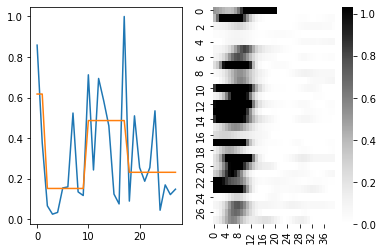

In [160]:
fig,axs=plt.subplots(1,2)
ax=axs[0]
ax.plot(signal)
ax.plot(xpwc)
ax=axs[1]
sns.heatmap(frmap_one,cmap='Greys',vmax=np.quantile(frmap_one.values,0.9))

In [13]:
mean_fr_across_trial

0         1         2         3         4         5   \
CA1 0  0 0 0    0.098327  0.044614  0.018461  0.067262  0.036043  0.046339   
           1    0.278612  0.338875  0.174773  0.424762  0.074119  0.089315   
           2    0.015044  0.137090  0.142609  0.140478  0.074740  0.042416   
           3    0.002532  0.014942  0.022928  0.034292  0.027940  0.022099   
           4    0.157750  0.029624  0.103516  0.076621  0.196670  0.111974   
...                  ...       ...       ...       ...       ...       ...   
DG  11 4 1 217  0.059749  0.244114  0.021396  0.092314  0.034580  0.033576   
           218  0.026698  0.035594  0.065787  0.011349  0.023208  0.030604   
           219  0.028283  0.183712  0.079113  0.015821  0.007961  0.008299   
           220  0.051806  0.052539  0.057092  0.037994  0.031647  0.032269   
           221  0.015248  0.002756  0.012897  0.007478  0.001893  0.006941   

                      6         7         8         9   ...        24  \
CA1 0  0 0 0    0.139416  0.111081  0.036272  0.068758  ...  0.027205   
           1    0.098231  0.236308  0.111645  0.037728  ...  0.023170   
           2    0.036432  0.146231  0.125862  0.074508  ...  0.061715   
           3    0.016098  0.040430  0.077790  0.038561  ...  0.103158   
           4    0.049799  0.057900  0.111505  0.118942  ...  0.107206   
...                  ...       ...       ...       ...  ...       ...   
DG  11 4 1 217  0.094083  0.032341  0.037440  0.030169  ...       NaN   
           218  0.048150  0.021864  0.031478  0.022403  ...       NaN   
           219  0.127610  0.065435  0.075594  0.005086  ...       NaN   
           220  0.051146  0.054207  0.026731  0.100599  ...       NaN   
           221  0.006118  0.000193  0.001007  0.006982  ...       NaN   

                      25        26        27  28  29  30  31  32  33  
CA1 0  0 0 0    0.058374  0.079883  0.052557 NaN NaN NaN NaN NaN NaN  
           1    0.138552  0.016283  0.092300 NaN NaN NaN NaN NaN NaN  
           2    0.065936  0.035891  0.071099 NaN NaN NaN NaN NaN NaN  
           3    0.032503  0.042059  0.049579 NaN NaN NaN NaN NaN NaN  
           4    0.059846  0.118644  0.044340 NaN NaN NaN NaN NaN NaN  
...                  ...       ...       ...  ..  ..  ..  ..  ..  ..  
DG  11 4 1 217       NaN       NaN       NaN NaN NaN NaN NaN NaN NaN  
           218       NaN       NaN       NaN NaN NaN NaN NaN NaN NaN  
           219       NaN       NaN       NaN NaN NaN NaN NaN NaN NaN  
           220       NaN       NaN       NaN NaN NaN NaN NaN NaN NaN  
           221       NaN       NaN       NaN NaN NaN NaN NaN NaN NaN  

[96110 rows x 34 columns]

In [127]:
toplot=per_cell_metrics.reset_index(level=(0,3)).rename({'level_0':'region','level_3':'isnovel'},axis=1)

In [133]:
per_cell_metrics.loc['DG'].loc[(slice(None),slice(None),0)]

si     fr_cv   mean_fr
0  0 0    0.436005  1.438903  0.028476
     1    0.319140  1.026805  0.025618
     2    0.104123  1.111700  0.025723
     3    0.805235  1.414308  0.024621
     4    0.302933  2.055589  0.025958
...            ...       ...       ...
11 4 217  0.550350  0.625058  0.058835
     218  0.583654  0.487394  0.028284
     219  0.143271  0.571479  0.051864
     220  0.593466  0.533241  0.047668
     221  1.664293  0.713343  0.011801

[10184 rows x 3 columns]

<Axes: xlabel='region', ylabel='fr_cv'>

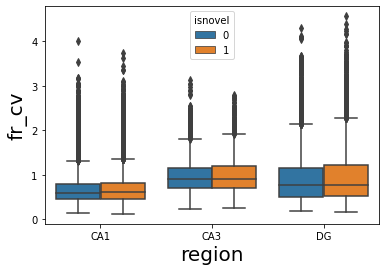

In [134]:
sns.boxplot(data=toplot,x='region',y='fr_cv',hue='isnovel')

<Axes: xlabel='region', ylabel='si'>

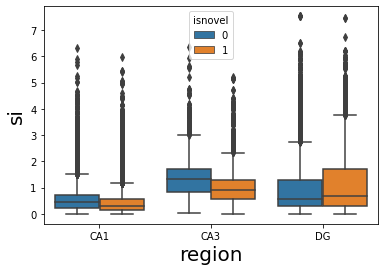

In [129]:
sns.boxplot(data=toplot,x='region',y='si',hue='isnovel')

In [277]:
region = 'CA1'
isnovel = 0
subdf=per_cell_metrics.loc[(region,slice(None),slice(None),isnovel),:].query('si>1.')
row=subdf.sample(1)
ind = row.index[0]
region,exp,day,isnovel,uid = ind

In [278]:
row

,,,,,si,fr_cv,mean_fr
CA1,11,3,0,156,1.009752,1.232906,0.040009


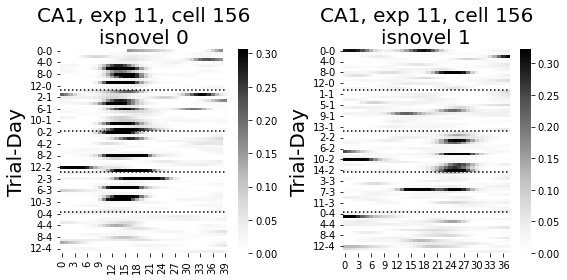

In [279]:
fig,axs=plt.subplots(1,2,figsize=(8,4))
for isnovel in [0,1]:
    ax=axs[isnovel]
#     ind = (region,exp,slice(None),isnovel,uid)
    xx=fr_map_trial_df_all.loc[(region,exp,slice(None),isnovel,uid),:].dropna(axis=1).droplevel((0,1,3,4))
    xx = xx.unstack(level=0).sort_index(level=1,axis=1)
#     xx = xx.loc[(slice(None),isnovel,uid),:].dropna(axis=1)
#     xx=fr_map_trial_df_all.loc[(region,exp,slice(None),isnovel,uid),:].dropna(axis=1).unstack(level=2).sort_index(level=1,axis=1)
    xx=xx.T

#     sns.heatmap(xx,cmap='Greys',ax=ax,vmax=np.quantile(xx.values,1.),vmin=0.)
#     sns.heatmap(xx,cmap='Greys',ax=ax,vmax=0.5 * xx.max().max())
    vmax=np.quantile(xx.dropna().values,0.99)
#     sns.heatmap(xx,cmap='Greys',ax=ax,vmax=np.quantile(xx.values,0.999))
    sns.heatmap(xx,cmap='Greys',ax=ax,vmax=vmax)
    day_l = xx.index.get_level_values(1)
    day_change = np.nonzero(np.diff(day_l))[0]+1
    for dd in day_change:
        ax.axhline(dd,color='k',linestyle=':')
    ax.set_ylabel('Trial-Day')
    ax.set_title(f'{region}, exp {exp}, cell {uid}\nisnovel {isnovel}')
plt.tight_layout()

In [135]:
np.nan<0

False

In [91]:
si_all

CA1  0   0  0  0      0.309986
               1      0.324866
               2      0.287752
               3      0.073741
               4      0.285012
                        ...   
DG   11  4  1  217    0.389956
               218    0.470853
               219    0.141306
               220    0.286179
               221    2.207477
Length: 96110, dtype: float64

In [88]:
si_all

CA1  0   0  0  0      0.309986
               1      0.324866
               2      0.287752
               3      0.073741
               4      0.285012
                        ...   
DG   11  4  1  217    0.389956
               218    0.470853
               219    0.141306
               220    0.286179
               221    2.207477
Length: 96110, dtype: float64

In [81]:
si_one = pa.get_si_one_field(frmap_one,row)

In [82]:
si_one

0      0.274439
1      0.945066
2      0.728491
3      0.907605
4      0.370489
         ...   
217    0.389956
218    0.470853
219    0.141306
220    0.286179
221    2.207477
Length: 222, dtype: float64

In [64]:
frmap_one

lin_binned,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,-0.048366,-0.040168,-0.026656,-0.011607,0.002067,0.012985,0.021229,0.027774,0.033669,0.039546,...,0.076003,0.077236,0.078142,0.078497,0.078087,0.076731,0.074456,0.071635,0.068972,0.067325
1,-0.003856,-0.003662,-0.003682,-0.004323,-0.005600,-0.006982,-0.007569,-0.006629,-0.004123,-0.000674,...,-0.001905,0.002847,0.007412,0.011440,0.014774,0.017439,0.019562,0.021266,0.022563,0.023302
2,0.022158,0.023554,0.024954,0.024547,0.021147,0.014948,0.007738,0.002074,-0.000164,0.001292,...,-0.014137,-0.009063,-0.003767,0.002127,0.008828,0.016133,0.023501,0.030227,0.035507,0.038473
3,-0.043317,-0.041728,-0.038994,-0.035584,-0.031766,-0.027665,-0.023259,-0.018233,-0.012164,-0.004998,...,0.017984,0.026525,0.035070,0.043267,0.050268,0.055291,0.058107,0.059060,0.058858,0.058399
4,-0.084857,-0.075773,-0.060091,-0.040864,-0.020466,-0.000783,0.016511,0.030566,0.041944,0.052005,...,0.130374,0.141030,0.153193,0.165198,0.174533,0.179534,0.180186,0.177712,0.174015,0.171317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,-0.019562,-0.015531,-0.008623,-0.000316,0.008113,0.015590,0.021320,0.025157,0.027756,0.030108,...,0.077552,0.078996,0.082550,0.089290,0.099321,0.111388,0.123446,0.133704,0.141086,0.144971
218,-0.014148,-0.012321,-0.009490,-0.006674,-0.004537,-0.003182,-0.002198,-0.000931,0.001167,0.004381,...,0.046754,0.049860,0.052795,0.054400,0.054154,0.052407,0.050036,0.047864,0.046339,0.045584
219,0.001974,0.007333,0.017504,0.031604,0.048234,0.065066,0.079177,0.088269,0.091548,0.089715,...,0.048331,0.047262,0.046106,0.044027,0.040711,0.036553,0.032329,0.028739,0.026200,0.024898
220,-0.036834,-0.032394,-0.024671,-0.015156,-0.004985,0.005287,0.015623,0.026108,0.036428,0.045804,...,0.049920,0.052594,0.055198,0.057636,0.060029,0.062629,0.065666,0.069089,0.072335,0.074398


In [63]:
row

lin_binned
0     3.841311
1     4.513452
2     4.830986
3     4.436628
4     3.871413
5     3.529677
6     3.338822
7     3.193413
8     3.118733
9     3.127953
10    3.265039
11    3.557300
12    3.809410
13    3.901053
14    3.994716
15    4.191885
16    4.444488
17    4.616895
18    4.620189
19    4.583455
20    4.584075
21    4.400268
22    3.922307
23    3.426132
24    3.154238
25    3.093779
26    3.194425
27    3.415733
28    3.669756
29    3.838567
30    3.828571
31    3.738025
32    3.760333
33    3.880919
34    4.003745
35    4.166156
36    4.261594
37    3.814807
38    3.009753
Name: (DG, 11, 4, 1), dtype: float64

In [62]:
si_one

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
217         NaN
218         NaN
219    0.141306
220         NaN
221         NaN
Length: 222, dtype: float64

In [51]:
row

lin_binned
0     3.841311
1     4.513452
2     4.830986
3     4.436628
4     3.871413
5     3.529677
6     3.338822
7     3.193413
8     3.118733
9     3.127953
10    3.265039
11    3.557300
12    3.809410
13    3.901053
14    3.994716
15    4.191885
16    4.444488
17    4.616895
18    4.620189
19    4.583455
20    4.584075
21    4.400268
22    3.922307
23    3.426132
24    3.154238
25    3.093779
26    3.194425
27    3.415733
28    3.669756
29    3.838567
30    3.828571
31    3.738025
32    3.760333
33    3.880919
34    4.003745
35    4.166156
36    4.261594
37    3.814807
38    3.009753
39         NaN
40         NaN
Name: (DG, 11, 4, 1), dtype: float64

In [47]:
reload(pa)
pa.get_si_one_field(frmap.iloc[0].dropna(),occu_map.iloc[0].dropna())

AxisError: axis 1 is out of bounds for array of dimension 1

In [29]:
frmap.groupby(level=(0,1,2,3))

lin_binned            0         1         2         3         4         5   \
CA1 0  0 0 0    0.050922  0.059354  0.077179  0.102963  0.129835  0.148244   
           1    0.086677  0.091032  0.096928  0.105445  0.117156  0.131663   
           2    0.095741  0.102615  0.116207  0.134926  0.153942  0.164095   
           3    0.070292  0.067602  0.062270  0.055693  0.050221  0.046127   
           4    0.028815  0.031121  0.035117  0.043349  0.061005  0.084880   
...                  ...       ...       ...       ...       ...       ...   
DG  11 4 1 217 -0.039965 -0.035306 -0.028301 -0.020951 -0.013980 -0.007344   
           218 -0.028999 -0.024436 -0.017966 -0.011881 -0.007082 -0.003715   
           219 -0.015993 -0.012970 -0.008270 -0.002756  0.003624  0.011424   
           220 -0.058828 -0.053961 -0.046370 -0.038005 -0.029671 -0.021527   
           221 -0.003172 -0.001182  0.001040  0.002082  0.001553 -0.000401   

lin_binned            6         7         8         9   ...        74  \
CA1 0  0 0 0    0.153676  0.148219  0.136871  0.123560  ...  0.020213   
           1    0.148892  0.168936  0.190415  0.210642  ... -0.008964   
           2    0.163323  0.158216  0.150609  0.141708  ...  0.086132   
           3    0.041966  0.037545  0.033192  0.029429  ...  0.035513   
           4    0.101046  0.108968  0.112261  0.111571  ... -0.019025   
...                  ...       ...       ...       ...  ...       ...   
DG  11 4 1 217 -0.000807  0.005735  0.012215  0.018528  ...  0.149061   
           218 -0.001772 -0.001182 -0.001533 -0.002030  ...  0.043417   
           219  0.021287  0.033505  0.047501  0.061774  ...  0.021684   
           220 -0.013723 -0.006678 -0.000816  0.003985  ...  0.070500   
           221 -0.003445 -0.007113 -0.010831 -0.014082  ...  0.029393   

lin_binned            75        76        77        78        79        80  \
CA1 0  0 0 0    0.024433  0.026246  0.025980  0.024231  0.021975  0.024430   
           1   -0.012389 -0.015344 -0.017898 -0.020496 -0.022033 -0.020515   
           2    0.074098  0.061554  0.050050  0.040173  0.032300  0.032173   
           3    0.027241  0.021316  0.017535  0.015391  0.014363  0.017735   
           4   -0.018781 -0.018350 -0.017884 -0.017183 -0.015872 -0.015594   
...                  ...       ...       ...       ...       ...       ...   
DG  11 4 1 217  0.152182  0.153404  0.153345  0.152536  0.151690       NaN   
           218  0.043405  0.044131  0.045305  0.046667  0.047745       NaN   
           219  0.021781  0.022531  0.023566  0.024651  0.025439       NaN   
           220  0.074540  0.078480  0.082031  0.085129  0.087308       NaN   
           221  0.032092  0.034248  0.036116  0.037827  0.039067       NaN   

lin_binned      81  82  83  
CA1 0  0 0 0   NaN NaN NaN  
           1   NaN NaN NaN  
           2   NaN NaN NaN  
           3   NaN NaN NaN  
           4   NaN NaN NaN  
...             ..  ..  ..  
DG  11 4 1 217 NaN NaN NaN  
           218 NaN NaN NaN  
           219 NaN NaN NaN  
           220 NaN NaN NaN  
           221 NaN NaN NaN  

[96110 rows x 84 columns]

In [26]:
gpb = fr_map_trial_df_all.groupby(level=(0,1,2,3),sort=False)
for k,val in gpb:
    val

In [27]:
val

0         1         2         3         4         5   \
DG 11 4 1 0   0  -0.097188 -0.067621 -0.136959 -0.008026 -0.065875 -0.065409   
              1  -0.085339 -0.061670 -0.120694 -0.009689 -0.054938 -0.066630   
              2  -0.069151 -0.053288 -0.096496 -0.010485 -0.037191 -0.066832   
              3  -0.053265 -0.045415 -0.072426 -0.008851 -0.017405 -0.064552   
              4  -0.037654 -0.039005 -0.052099 -0.005288  0.001948 -0.059879   
...                    ...       ...       ...       ...       ...       ...   
          221 75  0.072357 -0.012727  0.119959  0.029390  0.003434  0.002137   
              76  0.077524 -0.005706  0.114091  0.038334 -0.001363  0.000013   
              77  0.081090  0.001580  0.108241  0.045797 -0.004979 -0.001750   
              78  0.083348  0.008513  0.103291  0.051983 -0.007602 -0.002955   
              79  0.084442  0.013589  0.100224  0.055994 -0.009162 -0.003567   

                        6         7         8         9   ...  24  25  26  27  \
DG 11 4 1 0   0   0.005130 -0.048319 -0.137577 -0.081373  ... NaN NaN NaN NaN   
              1   0.010192 -0.039026 -0.124460 -0.073668  ... NaN NaN NaN NaN   
              2   0.015252 -0.024266 -0.103950 -0.060783  ... NaN NaN NaN NaN   
              3   0.018042 -0.008521 -0.080383 -0.045356  ... NaN NaN NaN NaN   
              4   0.018293  0.005399 -0.054698 -0.028934  ... NaN NaN NaN NaN   
...                    ...       ...       ...       ...  ...  ..  ..  ..  ..   
          221 75  0.013961 -0.010927 -0.043966  0.015460  ... NaN NaN NaN NaN   
              76  0.010486 -0.003110 -0.050450  0.023392  ... NaN NaN NaN NaN   
              77  0.006031  0.002396 -0.056016  0.031715  ... NaN NaN NaN NaN   
              78  0.001417  0.005784 -0.059934  0.040126  ... NaN NaN NaN NaN   
              79 -0.002021  0.007386 -0.061979  0.046711  ... NaN NaN NaN NaN   

                  28  29  30  31  32  33  
DG 11 4 1 0   0  NaN NaN NaN NaN NaN NaN  
              1  NaN NaN NaN NaN NaN NaN  
              2  NaN NaN NaN NaN NaN NaN  
              3  NaN NaN NaN NaN NaN NaN  
              4  NaN NaN NaN NaN NaN NaN  
...               ..  ..  ..  ..  ..  ..  
          221 75 NaN NaN NaN NaN NaN NaN  
              76 NaN NaN NaN NaN NaN NaN  
              77 NaN NaN NaN NaN NaN NaN  
              78 NaN NaN NaN NaN NaN NaN  
              79 NaN NaN NaN NaN NaN NaN  

[17760 rows x 34 columns]